In [1]:
import pandas as pd
import numpy as np
import rdkit
import pickle
from rdkit import Chem
from rdkit.Chem import rdmolops
from rdkit.Chem import Fragments
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from Descriptors_logPN import *
from Descriptors_logPI import *
from Descriptors_pKa import *

In [9]:
def logD_pH(logPN, logPI, pKa, Tipo, pH, printing):
    PN = pow(10, logPN)
    PI = pow(10, logPI)
    if Tipo == 'acid':
        delta = float(pH) - float(pKa)
    elif Tipo == 'basic':
        delta = float(pKa) - float(pH)
    logD = np.log10(PN + PI * pow(10, delta)) - np.log10(1 + pow(10, delta))
    logD_ = logPN - np.log10(1 + pow(10, delta))
    
    if printing == True:
        print('-------------------------')
        print('Taking into consideration logPI')
        print('logD at pH ', pH, ' = ', round(logD, 2))
        print('-------------------------')
        print('Not taking into consideration logPI')
        print('logD at pH ', pH, ' = ', round(logD_, 2))
        print('-------------------------')
    
    return logD, logD_

In [3]:
def logPN(mol):
    dataframe = conteo_descr(mol)
    train = pd.read_csv('train_logPN.csv')
    train = train.drop(['NAME', 'DATABASE_ID', 'SMILES','logP'], axis = 1)
    dataframe = dataframe[train.columns]
    
    XGB = pickle.load(open('XGB_logPN.sav', 'rb'))
 
    return XGB.predict(dataframe)

In [4]:
def logPI(mol1, mol2):
    dataframe = conteo_descr_(mol1, mol2)
    train = pd.read_csv('train_logPI.csv')
    train = train.drop(['NAME', 'DATABASE_ID', 'SMILES', 'SMILES_cargado', 'logPN', 'logPI', 'Delta'], axis = 1)
    dataframe = dataframe[train.columns]
    
    f2 = dataframe
    f2['Delta_MR'] = f2['MR'] - f2['MR_carg']
    f2['Delta_PSA'] = f2['PSA'] - f2['PSA_carg']
    E2 = f2.drop(['MR', 'MR_carg', 'PSA', 'PSA_carg'], axis = 1)
    
    RF = pickle.load(open('RF_logPI.sav', 'rb'))
    
    return RF.predict(E2)

In [5]:
def pKa(mol1, mol2, Type):
    dataframe = descriptor(mol1, mol2, Type)
    
    XGB = pickle.load(open('XGB_pKa.sav', 'rb'))
    return XGB.predict(dataframe)

In [6]:
def SMILES_to_logD(Image):
    SMI1 = input('Enter the SMILES string of your neutral molecule: ')
    SMI2 = input('Enter the SMILES string of your charged molecule: ')
    
    mol1 = Chem.MolFromSmiles(SMI1)
    mol2 = Chem.MolFromSmiles(SMI2)
    
    carga1 = Chem.rdmolops.GetFormalCharge(mol1)
    carga2 = Chem.rdmolops.GetFormalCharge(mol2)
    
    if carga1 == 0 and carga2 == 1:
        Tipo = 'basic'
    elif carga1 == 0 and carga2 == -1:
        Tipo = 'acid'
    else: 
        print('Review the SMILES strings order, remember this program only supports monobasic and monoprotic compounds')
        return
    
    logPN_ = logPN(mol1)
    logPI_ = logPN_ - logPI(mol1, mol2)
    
    if Tipo == 'acid':
        pKa_ = pKa(mol2, mol1, Tipo)
    elif Tipo == 'basic':
        pKa_ = pKa(mol1, mol2, Tipo)
     
    
    pH = input('Enter the pH you want to predict your logD: ')
    
  
    if Image == True:
        print('--------------------------------------------------------')
        print('The molecule is:', Tipo)
        print('logPN:', round(logPN_[0], 2))
        print('logPI:', round(logPI_[0], 2))
        print('pKa:', round(pKa_[0], 2))
        logD1, logD2 = logD_pH(logPN_[0], logPI_[0], pKa_[0], Tipo, pH, printing = True)
        return Draw.MolsToGridImage((mol1, mol2), returnPNG = False, molsPerRow = 2)
    else:
        logD1, logD2 = logD_pH(logPN_[0], logPI_[0], pKa_[0], Tipo, pH, printing = False)        
        return np.array([logPN_[0], logPI_[0], pKa_[0], logD1, logD2])

In [7]:
def File_logD(filename):
    file = pd.read_csv(filename)
    total = []
    
    logPN_db = pd.read_csv('train_logPN.csv')
    logPI_db = pd.read_csv('train_logPI.csv')
    pKa_db = pd.read_csv('train_pKa.csv')
    
    SMILES_logPN = logPN_db['SMILES']
    SMILES_logPI = logPI_db['SMILES']
    SMILES_pKa = pKa_db['SMILES_1']
    SMILES_pKa = SMILES_pKa.append(pKa_db['SMILES_2'])
    
    new_SMILES_logPN = []
    for x in SMILES_logPN:
        mol = Chem.MolFromSmiles(x)
        new_SMILES_logPN.append(Chem.MolToSmiles(mol))
        
    new_SMILES_logPI = []
    for x in SMILES_logPI:
        mol = Chem.MolFromSmiles(x)
        new_SMILES_logPI.append(Chem.MolToSmiles(mol))
    
    new_SMILES_pKa = []
    for x in SMILES_pKa:
        mol = Chem.MolFromSmiles(x)
        new_SMILES_pKa.append(Chem.MolToSmiles(mol))
    
    for i in range(len(file)):
        SMI1 = file.loc[i, 'SMILES_neu']
        SMI2 = file.loc[i, 'SMILES_carg']
        
        mol1 = Chem.MolFromSmiles(SMI1)
        mol2 = Chem.MolFromSmiles(SMI2)
        
        SMI1 = Chem.MolToSmiles(mol1)
        SMI2 = Chem.MolToSmiles(mol2)
        
        bool1 = SMI1 in new_SMILES_logPN
        bool2 = SMI1 in new_SMILES_logPI
        bool3 = SMI1 in new_SMILES_pKa or SMI2 in new_SMILES_pKa
            
        carga1 = Chem.rdmolops.GetFormalCharge(mol1)
        carga2 = Chem.rdmolops.GetFormalCharge(mol2)
    
        if carga1 == 0 and carga2 == 1:
            Tipo = 'basic'
        elif carga1 == 0 and carga2 == -1:
            Tipo = 'acid'
        else: 
            print('Review the SMILES strings order, remember this program only supports monobasic and monoprotic compounds')
            return
    
        logPN_ = logPN(mol1)
        logPI_ = logPN_ - logPI(mol1, mol2)
    
        if Tipo == 'acid':
            pKa_ = pKa(mol2, mol1, Tipo)
        elif Tipo == 'basic':
            pKa_ = pKa(mol1, mol2, Tipo)
     
    
        pH = file.loc[i, 'pH']
        
        logD1, logD2 = logD_pH(logPN_[0], logPI_[0], pKa_[0], Tipo, pH, printing = False)
        
        obs = np.array([logPN_[0], logPI_[0], pKa_[0], logD1, logD2, bool1, bool2, bool3])
        
        total.append(obs)
    
    total_ = pd.DataFrame(total, columns = ['logPN', 'logPI', 'pKa', 'logD1', 'logD2', 'train_logPN', 'train_logPI', 'train_pKa'])
    
    name = filename.split('.')
    name = name[0]
    
    df = pd.concat([file, total_], axis = 1)
    
    new_file = name + '_logD_pred.csv'
    
    df.to_csv(new_file, index = False)
   
    return df

Enter the SMILES string of your neutral molecule: CC(=O)O
Enter the SMILES string of your charged molecule: CC(=O)[O-]
Enter the pH you want to predict your logD: 3
--------------------------------------------------------
The molecule is: acid
logPN: -0.27
logPI: -3.95
pKa: 5.2
-------------------------
Taking into consideration logPI
logD at pH  3  =  -0.27
-------------------------
Not taking into consideration logPI
logD at pH  3  =  -0.27
-------------------------


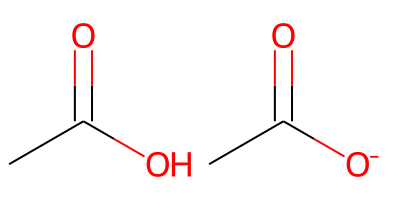

In [10]:
#### Function SMILES_to_logD((Boolean)Image)
# Boolean parameter. If True it prints the predicted values and renders images of the molecule structure in its neutral and
# ionized form.If False it returns an array of floats with the predicted logPN, logPI, pKa, logD considering ionic partition,
# and log D without considering ionic partition. 

# Functions akss user to enter SMILES string of the neutral species, SMILES string of the ionic form and pH. 
# If an invalid SMILES is entered or not in the required order returns error.

# Try Neutral Molecule: CC(=O)O
# Try Charged Molecule: CC(=O)[O-]
# Try pH of interest
# Image = True

SMILES_to_logD(True)

In [12]:
# Try Neutral: CN(C)CCCN1C2=CC=CC=C2SC3=C1C=C(C=C3)Cl
# Try Ionic: C[NH+](C)CCCN1C2=CC=CC=C2SC3=C1C=C(C=C3)Cl
# TRy pH of interest

predictions = SMILES_to_logD(False)
predictions

Enter the SMILES string of your neutral molecule: CN(C)CCCN1C2=CC=CC=C2SC3=C1C=C(C=C3)Cl
Enter the SMILES string of your charged molecule: C[NH+](C)CCCN1C2=CC=CC=C2SC3=C1C=C(C=C3)Cl
Enter the pH you want to predict your logD: 5


array([4.92585278, 1.71205278, 9.27370262, 1.74830549, 0.65212703])

In [8]:
#### Function File_logD((string)filename)
# File must be a csv with a column name 'SMILES_neu', 'SMILES_carg' and 'pH'
# Function returns a file with the same name plus logD_pred

# Try and look at the file included in the git 'test.csv'

a = File_logD('test.csv')